In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [10]:
df = pd.read_csv('helen_2015_2021b.csv', delimiter=';')
df = df.set_index('date_time')
df.index = pd.to_datetime(df.index)
df['dh_MWh'] = df['dh_MWh'].str.replace(',','.').astype(float)
df.head()

,dh_MWh
date_time,
2015-01-01 00:00:00,924.2
2015-01-01 01:00:00,926.3
2015-01-01 02:00:00,942.1
2015-01-01 03:00:00,957.1
2015-01-01 04:00:00,972.2


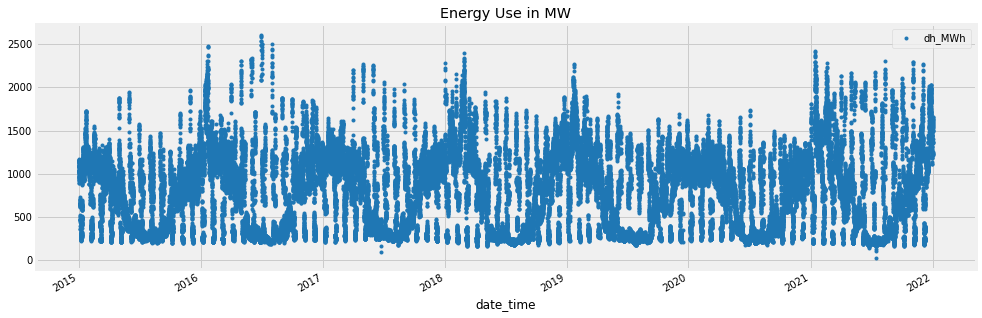

In [11]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Energy Use in MW')
plt.show()

# 1. Outlier analysis and removal

<AxesSubplot:ylabel='Frequency'>

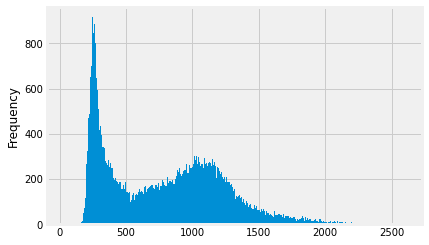

In [12]:
df['dh_MWh'].plot(kind='hist', bins=500)

<AxesSubplot:title={'center':'Outliers'}, xlabel='date_time'>

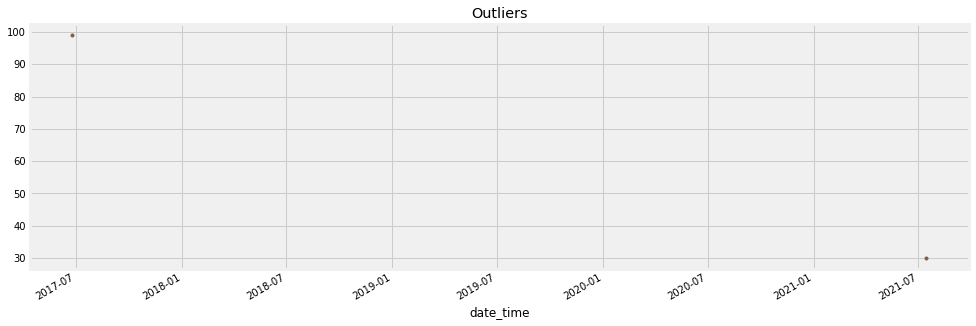

In [14]:
df.query('dh_MWh < 100')['dh_MWh'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

**Seems that there are some values < 100. Let's remove those.**

In [15]:
df = df.query('dh_MWh > 100').copy()

# 2. Time series cross validation

In [16]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

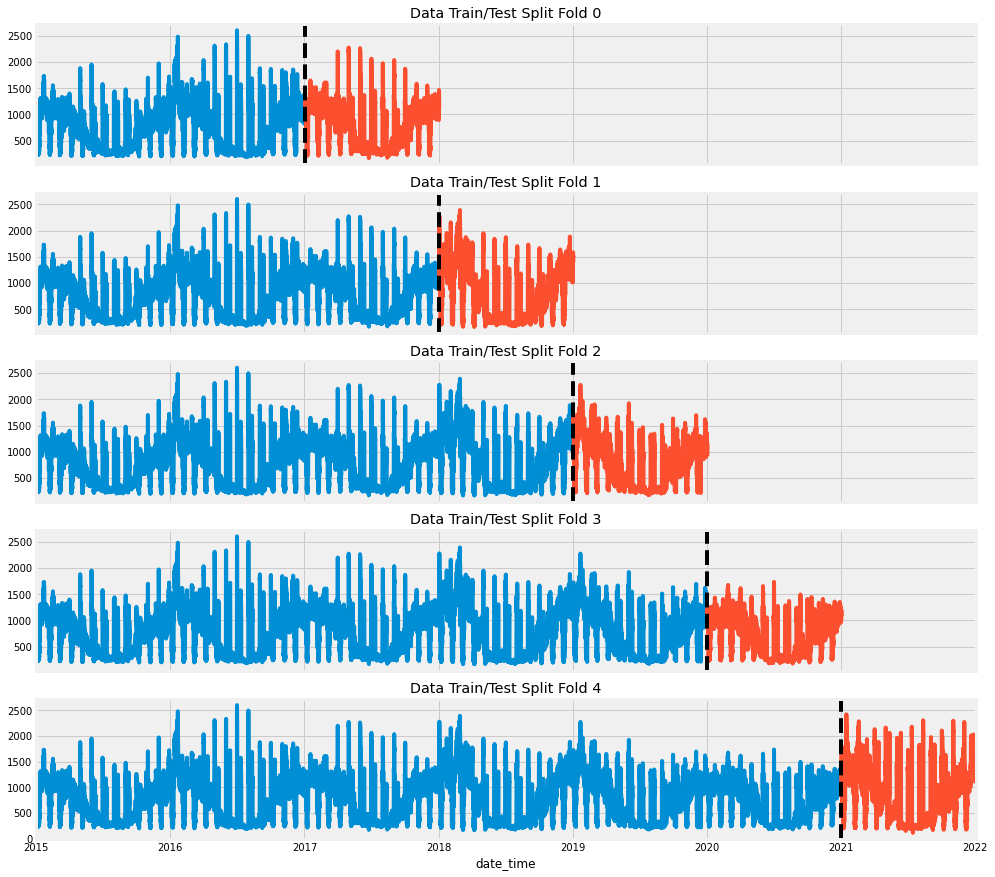

In [17]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['dh_MWh'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['dh_MWh'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Forecasting horizon

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [18]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Lag features

What was the target (x) days in the past.

In [21]:
def add_lags(df):
    target_map = df['dh_MWh'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)

## Train using Cross-validation

In [22]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'dh_MWh'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[16:22:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:870.74876	validation_1-rmse:892.58142
[100]	validation_0-rmse:439.56302	validation_1-rmse:417.10496
[200]	validation_0-rmse:327.08695	validation_1-rmse:303.34224
[300]	validation_0-rmse:295.54382	validation_1-rmse:279.20488
[400]	validation_0-rmse:277.33793	validation_1-rmse:267.59067
[500]	validation_0-rmse:264.02313	validation_1-rmse:258.38390
[600]	validation_0-rmse:255.67112	validation_1-rmse:255.29985
[700]	validation_0-rmse:245.23209	validation_1-rmse:249.34899
[800]	validation_0-rmse:234.51153	validation_1-rmse:242.40420
[900]	validation_0-rmse:225.08011	validation_1-rmse:236.66456
[999]	validation_0-rmse:217.63259	validation_1-rmse:231.90387
[16:22:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpyth

In [23]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 269.7904
Fold scores:[231.9038743374307, 270.5158238202843, 226.6856177969446, 277.0964123623492, 342.750468642187]


## Predicting the future

- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [24]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'dh_MWh'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:898.02127
[100]	validation_0-rmse:439.33900
[200]	validation_0-rmse:322.37822
[300]	validation_0-rmse:291.06217
[400]	validation_0-rmse:277.34097
[499]	validation_0-rmse:270.20737


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [25]:
df.index.max()

Timestamp('2022-01-01 23:00:00')

In [29]:
# Create future dataframe
future = pd.date_range('2022-01-01','2023-01-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

In [30]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

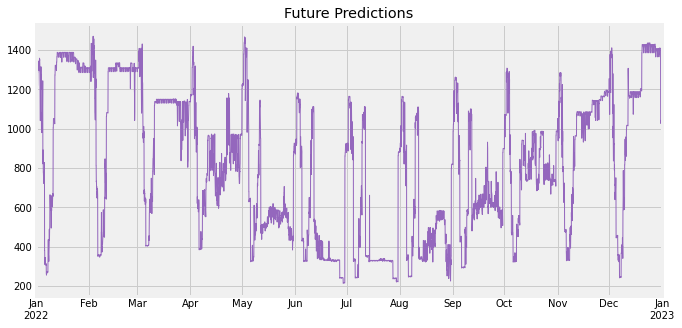

In [31]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()